<a href="https://colab.research.google.com/github/anniebritton/Ecological-Drought-ML-Modeling/blob/main/NDVI_Modeling_Process_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊🛰️ Data processing scripts, ML models, and Explainable AI results created as part of my Masters Thesis @ Johns Hopkins: **An Interpretable Machine Learning Model to Explore Relationships between Drought Indices and Ecological Drought Impacts in the Cheyenne River Basin, USA**

---

# **Abstract**
Rangeland ecosystems across the United States have significant biological, economic, and cultural value. However, the increasing frequency and severity of droughts across the country may lead to unforeseen impacts on these ecosystems. To address this challenge, this study aimed to identify relationships between drought indices and vegetation health in the Cheyenne River Basin, USA, using machine learning (ML) and explainable artificial intelligence (XAI) methods. Using Terra Moderate Resolution Imaging Spectroradiometers (MODIS), University of Idaho Gridded Surface Meteorological Dataset (gridMET), and Daymet data, the study employed XGBoost Regressor and Extra Trees Regressor models in unison with SHapley Additive exPlanations (SHAP) to evaluate predictive performance and the connections between drought indices, environmental variables, and the Normalized Difference Vegetation Index (NDVI). Tests of model performance demonstrated that the XGBoost model performed moderately well at predicting NDVI and was therefore useful for further XAI analysis with SHAP. SHAP explainer results showed that the Palmer Drought Severity Index (PDSI), the 90-day Standardized Precipitation Index (SPI), and snow water equivalent (SWE), were the most important predictors of NDVI values and are therefore closely associated with vegetation health in the study area. The findings of this study first demonstrate the feasibility and usefulness of applying XAI, an underutilized method in the drought space, to study ecological drought indicators. Secondly, results provide an understanding of which commonly used drought indices correlate with effects on vegetation health in the study area, as well as the specific directionality of these relationships. These results can be used to inform drought research and monitoring practices and anticipate ecological drought impacts in the Cheyenne River Basin.

**Advisor and Primary Reader: Dr. Garrett Graham**

**Secondary Reader: Dr. Michael Schwebel**


---

# **[Full Paper](https://jscholarship.library.jhu.edu/handle/1774.2/68152)**


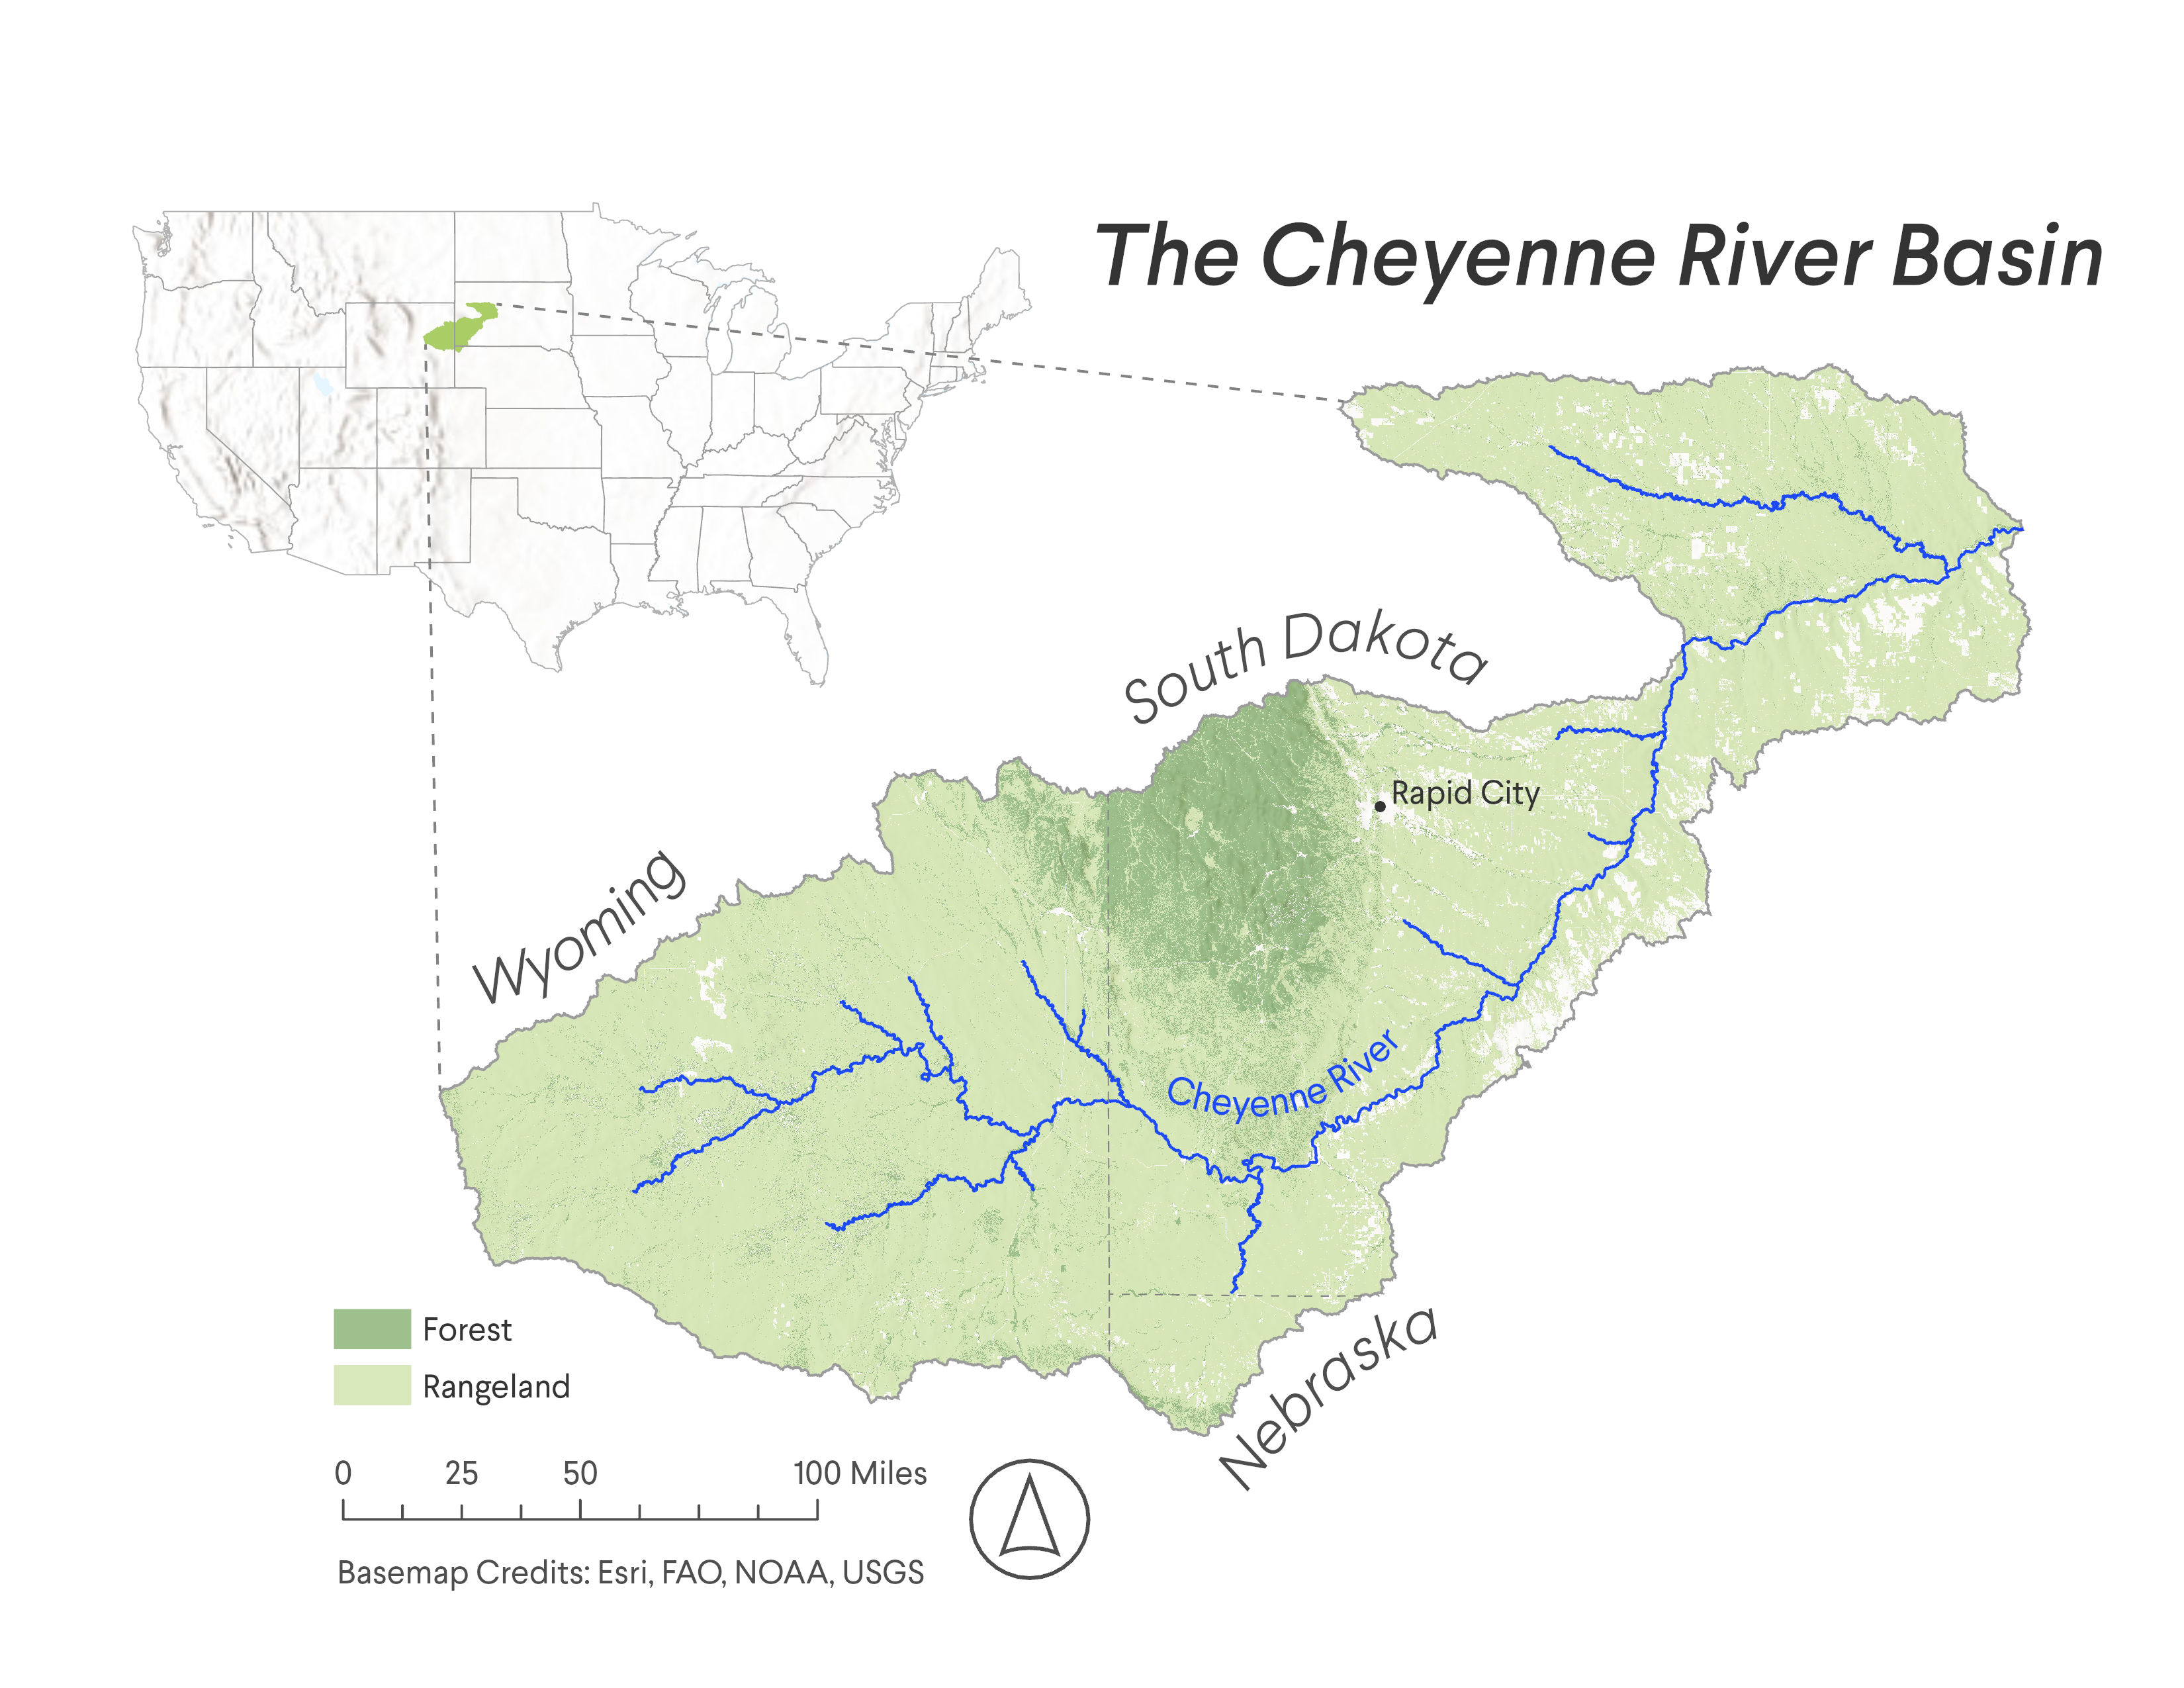

#**Colab Set Up**

First, we have to set up a Google Colab environment and import necessary libraries for conducting data analysis and machine learning tasks. The provided code installs and imports various libraries that will be used throughout the walkthrough in subsequent sections.

In [ ]:
# installs and import libraries
!pip install earthengine-api --upgrade
!pip install geemap
!pip install geopandas 
!pip install matplotlib
!pip install pyshp
!pip install PyCRS
!pip install lazypredict
!pip install shap

# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# GEE
import ee
import shapefile
import geemap.foliumap as geemap

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# Other Tools
import lazypredict
from lazypredict.Supervised import LazyRegressor
import shap
from joblib import dump, load

This code snippet initializes the Google Earth Engine (GEE) Python API by authenticating the user and initializing the Earth Engine object.

In [ ]:
# initialise ee, copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

This code snippet mounts Google Drive in the Google Colab environment, allowing access to files and directories stored in the user's Google Drive. Mounting Google Drive in Colab allows easy access to files stored in Google Drive, enabling data import, export, and collaboration with files stored in the user's Google Drive account.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# **Import the Shapefile**

Next, we import our shapefile. This code snippet selects the path to a shapefile in Google Drive, in this case one for the Cheyenne River Basin, and converts it into an Earth Engine object using the geemap.shp_to_ee() function.

In [ ]:
# import and create a variable for the shapefile
AOI_path = '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Shapefiles/Cheyenne_Basin/Cheyenne_Basin_whole.shp'

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)

#**Setting up the masking and preprocessing for the MODIS NDVI Data**

Next, we can set up the snow and cloud pixel masking for the MODIS data. This code defines two functions to mask out cloudy and snowy pixels in MODIS surface reflectance images. It then retrieves the MODIS surface reflectance image collection from GEE and applies the masking functions to filter and preprocess the images.

In [ ]:
# First, a function to mask out cloudy pixels
def mask_clouds(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal cloud algorithm flag bit
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Next, a function to mask out pixels with snow
def mask_snow(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 15, the internal snow mask bit
    bit_mask = 1 << 15
    # Return an image masking out snowy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection("MODIS/006/MOD09GA")

# Filter image collections by date and apply the mask_clouds and mask_snow functions
mod09ga_masked = mod09ga.filterDate('2000-02-24', '2021-12-31').map(mask_clouds).map(mask_snow)

This code then defines a function to calculate the Normalized Difference Vegetation Index (NDVI) and add it as a new band to the MODIS surface reflectance image collection. It then applies this function to the previously filtered and masked image collection.

In [ ]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

# **Data Set Up**

Next, we need to start to retrieve our data. This code defines several lists, each containing information about different Earth Engine image collections and their respective variables. These lists are used to retrieve specific data for analysis and modeling purposes.

In [ ]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]

# Daymet
swe_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-24','2021-12-31'), 'swe', AOI, 1000]

# gridMET Meteorology
tmin_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'tmmn', AOI, 4638.3]
tmax_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'tmmx', AOI, 4638.3]
precip_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'pr', AOI, 4638.3]

# gridMET Drought
pdsi_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'pdsi', AOI, 4638.3]
palmerz_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'z', AOI, 4638.3]

spei30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei30d', AOI, 4638.3]
spei90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei90d', AOI, 4638.3]
spei180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei180d', AOI, 4638.3]

spi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi30d', AOI, 4638.3]
spi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi90d', AOI, 4638.3]
spi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi180d', AOI, 4638.3]

eddi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi30d', AOI, 4638.3]
eddi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi90d', AOI, 4638.3]
eddi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi180d', AOI, 4638.3]

# **Function for Creating a Timeseries of Spatially Averaged Data**

Then, we define a function called spatialtimeseries that takes the lists we made above as arguments. This function performs spatial and temporal analysis on Earth Engine image collections and returns a pandas DataFrame with dates and corresponding mean values for a specific band within a given region of interest.

In [ ]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # Map this function to every image in our collection to get a new 
    # ImageCollection, but now each image has the mean value for the region of interest and the date. 
    aoi_reduced_imgs = data.map(aoi_mean)

    # Reduce the images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor.
    # Call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Set the date column to be the index.
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index('date')

    return(df)

Lastly, we call the spatialtimeseries function for different Earth Engine image collections and assign the returned pandas DataFrames to respective variables.



In [ ]:
# NDVI
NDVI_df = spatialtimeseries(NDVI_list)

In [ ]:
# Daymet
swe_df = spatialtimeseries(swe_list)

In [ ]:
# gridMET Meteorology
tmin_df = spatialtimeseries(tmin_list)
tmax_df = spatialtimeseries(tmax_list)
precip_df = spatialtimeseries(precip_list)

In [ ]:
# gridMET Drought
pdsi_df = spatialtimeseries(pdsi_list)
palmerz_df = spatialtimeseries(palmerz_list)

In [ ]:
eddi30_df = spatialtimeseries(eddi30_list)
eddi90_df = spatialtimeseries(eddi90_list)
eddi180_df = spatialtimeseries(eddi180_list)

In [ ]:
spei30_df = spatialtimeseries(spei30_list)
spei90_df = spatialtimeseries(spei90_list)
spei180_df = spatialtimeseries(spei180_list)

In [ ]:
spi30_df = spatialtimeseries(spi30_list)
spi90_df = spatialtimeseries(spi90_list)
spi180_df = spatialtimeseries(spi180_list)

# **Concatenate Dataframes**

After executing the code below, the df_whole DataFrame will contain a consolidated dataset with the "mean" values of different variables (swe, tmin, tmax, etc.) over time, indexed by date. This consolidated dataset will be used for further modeling tasks.

In [ ]:
# Create a list of the dataframe names
df_list = [swe_df, tmin_df, tmax_df, precip_df, pdsi_df, palmerz_df,
eddi30_df, eddi90_df, eddi180_df,  
spei30_df, spei90_df, spei180_df,  
spi30_df, spi90_df, spi180_df, 
NDVI_df]

# Create a list of the variables names
var_names = ['swe', 'tmin', 'tmax', 'precip', 'pdsi', "palmerz",
'eddi30', 'eddi90', 'eddi180', 
'spei30', 'spei90', 'spei180',
'spi30', 'spi90', 'spi180', 
'NDVI']

# Create an empty dataframe to fill
df_whole = pd.DataFrame()

# Set the index to match the index of the data 
# using tmin because it runs for the full daily series of data
df_whole.index = tmin_df.index

# For loop that adds each column to the new df and renames it
for i, df in enumerate(df_list):
  df_whole[var_names[i]] = df['mean']

# reset the index to avoid annoying datetime issues
df_whole = df_whole.reset_index()
df_whole['date'] = pd.to_datetime(df_whole['date'], utc=True)
df_whole = df_whole.set_index('date')

The df_whole DataFrame is a consolidated dataset that contains the combined information from various spatial time series datasets.

In [ ]:
df_whole

,swe,tmin,tmax,precip,pdsi,palmerz,eddi30,eddi90,eddi180,spei30,spei90,spei180,spi30,spi90,spi180,NDVI
date,,,,,,,,,,,,,,,,
2000-02-24 00:00:00+00:00,17.53,270.66,287.24,0.32,1.12,0.86,-0.19,0.06,0.53,0.69,0.05,-0.40,0.95,0.28,-0.28,0.23
2000-02-25 00:00:00+00:00,15.91,270.41,281.55,4.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-26 00:00:00+00:00,15.41,268.57,280.28,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25
2000-02-27 00:00:00+00:00,15.35,268.59,285.13,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23
2000-02-28 00:00:00+00:00,13.71,272.05,289.07,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26 00:00:00+00:00,1.17,258.48,275.76,0.30,-0.98,-0.28,1.62,1.37,1.61,-0.65,0.14,-0.53,0.65,0.86,0.63,0.22
2021-12-27 00:00:00+00:00,1.45,255.44,271.68,0.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23
2021-12-28 00:00:00+00:00,1.59,254.95,267.23,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28


#**Calculate Anomalies**

Next, we start to preprocess our data. This code snippet defines a function called calculate_anomaly that calculates the daily mean for each variable in a DataFrame and subsequently computes the anomaly for each variable/day.

Here's how the function works:


1.   It takes two parameters: df (the DataFrame) and value_col (the column name representing the variable for which the anomaly is calculated).

2.   The function groups the data in the DataFrame by the day of the year and calculates the average value for each day. This is done using the groupby function and the mean method.

3. The average values for each day of the year are stored in a dictionary, mapping the day of the year to the corresponding mean value.

4. The function creates a new column called 'day_of_year' in the DataFrame, which contains the day of the year for each entry.

5. It creates another column in the DataFrame, named 'day_of_year_{value_col}_mean', which maps the day of the year to the average value for that specific day. This is done by using the map function with the previously created dictionary.

6. Finally, the function calculates the daily anomaly by subtracting the original value (from the value_col column) from the corresponding average value for that day of the year. The resulting anomaly values are stored in a new column called '{value_col}_anomaly'.

The function is then applied to each column of the df_whole DataFrame (except the 'date' column) using a loop. This process calculates the anomalies for all the variables in the DataFrame, allowing for further analysis and interpretation of the data in terms of deviations from the average values for each day of the year.

In [ ]:
# Function that will calculate the daily mean for each variable and then 
# subsequently calculate the anomaly for each variable/day
def calculate_anomaly(df, value_col):
    
    # Group the data by day of the year and calculate the average for each day of the year
    df_daily_grouping = df.groupby(df.index.dayofyear).mean()

    # Create a dictionary mapping day of year to average value
    day_of_year_to_mean = df_daily_grouping[value_col].to_dict()

    # Map the day of year to the average value for that day of year
    df['day_of_year'] = df.index.dayofyear
    df[f'day_of_year_{value_col}_mean'] = df['day_of_year'].map(day_of_year_to_mean)

    # Calculate the daily anomaly as the difference between the original value and the average value for that day of year
    df[f'{value_col}_anomaly'] = df[value_col] - df[f'day_of_year_{value_col}_mean']

# NOTE - I am doing this before resampling we want to look at each day of the year here.
# If we did this after resampling, because of the way the pentads work, we would have
# less data to compare year to year.

# Apply the function to each column of the dataframe
for col in df_whole.columns:
    if col != 'date':
        calculate_anomaly(df_whole, col)

This code snippet reduces the df_whole DataFrame to include only the columns that represent the anomaly data. It also moves the 'NDVI_anomaly' column to the first position in the DataFrame to make our lives a bit easier later on.

In [ ]:
# Reduce the dataframe so that it only contains the anomaly data
df_anom = df_whole[df_whole.columns[df_whole.columns.str.endswith('_anomaly')]]

# Move the NDVI column to the first position in the dataframe
df_anom.insert(0, 'NDVI_anomaly', df_anom.pop('NDVI_anomaly'))

The resulting df_anom DataFrame contains the anomaly data, with the 'NDVI_anomaly' column positioned at the beginning.

In [ ]:
df_anom

,NDVI_anomaly,swe_anomaly,tmin_anomaly,tmax_anomaly,precip_anomaly,pdsi_anomaly,palmerz_anomaly,eddi30_anomaly,eddi90_anomaly,eddi180_anomaly,spei30_anomaly,spei90_anomaly,spei180_anomaly,spi30_anomaly,spi90_anomaly,spi180_anomaly
date,,,,,,,,,,,,,,,,
2000-02-24 00:00:00+00:00,0.04,2.88,8.33,12.15,-0.44,1.30,0.67,0.00,0.07,0.37,0.45,-0.06,-0.26,0.73,0.11,-0.24
2000-02-25 00:00:00+00:00,NaN,1.10,9.66,7.25,3.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-26 00:00:00+00:00,0.04,0.54,7.24,4.39,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-27 00:00:00+00:00,0.05,0.27,5.07,8.00,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-28 00:00:00+00:00,NaN,-1.41,7.32,11.19,-0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26 00:00:00+00:00,-0.03,-6.02,-3.22,1.90,-0.69,-0.69,-0.13,1.44,1.12,1.31,-0.50,0.41,-0.23,0.60,0.97,0.67
2021-12-27 00:00:00+00:00,-0.00,-5.88,-6.63,-2.74,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28 00:00:00+00:00,0.04,-6.11,-6.73,-6.60,-0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#**Resample the Data to match the Pentads from the Drought Indexes, and Standardize**

For our next step, we need to resample, smooth, and standardize our data. First, we will import and create a list of pentads that the drought data is based on. This will be used to calculate anomalies and average so that all of the data variables match temporally.

In [ ]:
pentads = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_variable_pentads.csv')
pentads = pentads[1470:]
pentads = pentads['date'].tolist()

Our next code snippet narrows down the data to pentads, which are periods of 5 days, by taking a rolling average over a window of 30 days. It then standardizes the data.

Here's how the code works:

1. An empty list called results is created to store the resulting DataFrames.

2. A loop is used to iterate through each column in the df_anom DataFrame.

3. For each column, a new DataFrame called result is created. It has two columns: 'date' and a new column name that includes '_roll' to indicate it represents the rolling average. The rolling average is calculated using the rolling method with a window size of 30 and a minimum of 1 period. The resulting rolling average values are selected based on the pentads variable.

4. The 'date' column is set as the index of the result DataFrame.

5. The result DataFrame is appended to the results list.

6. After the loop, the results DataFrames are concatenated into a single DataFrame called anom_result using pd.concat. The concatenation is done along the columns (axis=1).

7. The first row of anom_result is removed since it represents the rolling average of the initial 30-day window and may not be based on a complete 5-day average.

8. The data in anom_result is standardized by subtracting the mean and dividing by the standard deviation. This is done to scale the data and bring it to a standard distribution.

The resulting DataFrame, standardized_df, contains the standardized data for each variable, with the rolling average calculated over pentads.

In [ ]:
# create an empty list to store the result dataframes
results = []

# loop through each column in the dataframe
for col in df_anom.columns:
    if col == 'NDVI_anomaly':
        result = pd.DataFrame({'date': pentads, f'{col}_roll': df_anom[col].rolling(window=30, min_periods=1).mean().loc[pentads]})
    else:
        result = pd.DataFrame({'date': pentads, f'{col}_roll': df_anom[col].rolling(window=30, min_periods=1).mean().loc[pentads]})
    result = result.set_index('date')
    results.append(result)

# concatenate the result dataframes into a single dataframe
anom_result = pd.concat(results, axis=1)

# remove the first row since that row is not based on a 5-day average
anom_result = anom_result[1:]

# standardize the data
standardized_df = (anom_result-anom_result.mean())/anom_result.std()

The last code snippet for this section performs column renaming and capitalization on the standardized_df DataFrame.

In [ ]:
# Get column names that end with "_anomaly_roll"
columns_to_rename = [col for col in standardized_df.columns if col.endswith('_anomaly_roll')]

# Create a mapping of old column names to new column names
rename_dict = {col: col[:-len('_anomaly_roll')].upper() for col in columns_to_rename}

# Rename columns in the DataFrame and capitalize column names
standardized_df.rename(columns=rename_dict, inplace=True)
standardized_df.rename(columns={'TMIN': 'Tmin', 'TMAX': 'Tmax', 'PRECIP': 'Precip', 'PALMERZ': 'PalmerZ',}, inplace=True)

# Check the df
standardized_df

,NDVI,SWE,Tmin,Tmax,Precip,PDSI,PalmerZ,EDDI30,EDDI90,EDDI180,SPEI30,SPEI90,SPEI180,SPI30,SPI90,SPI180
date,,,,,,,,,,,,,,,,
2000-02-29,0.78,0.02,3.87,3.20,0.59,0.57,0.22,0.33,0.19,0.50,0.18,-0.05,-0.46,0.82,0.34,-0.51
2000-03-05,0.36,-0.43,3.35,3.17,0.14,0.56,0.10,0.57,0.30,0.61,-0.06,-0.11,-0.66,0.70,0.33,-0.77
2000-03-10,0.29,-0.81,2.55,2.29,1.80,0.56,0.42,0.61,0.33,0.68,0.29,0.08,-0.68,1.12,0.65,-0.69
2000-03-15,0.07,-0.92,1.68,1.55,1.17,0.57,0.51,0.64,0.29,0.71,0.39,0.24,-0.69,1.22,0.84,-0.63
2000-03-20,0.01,-0.95,1.25,1.19,1.11,0.58,0.58,0.63,0.27,0.76,0.47,0.35,-0.71,1.30,0.97,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,0.68,-0.48,1.73,1.59,-0.31,-0.25,-0.32,0.90,1.15,1.27,-0.92,0.01,-0.66,-0.49,0.82,0.29
2021-12-11,0.68,-0.51,1.59,1.53,0.10,-0.27,-0.42,1.20,1.22,1.30,-1.25,-0.04,-0.63,-0.52,0.81,0.36
2021-12-16,0.40,-0.51,1.54,1.40,0.12,-0.28,-0.48,1.37,1.31,1.32,-1.43,-0.06,-0.56,-0.53,0.82,0.46


#**Prelim ML Test**

Now we can finally move into the Machine Learning portion of our script. As a first test to make sure our data is formatted correctly, the code below demonstrates the use of a Decision Tree Regressor for predicting the target variable based on the features in the standardized_df DataFrame.

The clf.score(X_test, Y_test) line returns the R^2 score, which indicates the goodness of fit of the model. The score ranges between -inf and 1, where a value closer to 1 indicates a better fit.

In [ ]:
# try a decision tree regressor
from sklearn import tree

X = standardized_df.iloc[:,1:16].values
Y = standardized_df.iloc[:,0:1].values.ravel()

clf = tree.DecisionTreeRegressor()

X_train = standardized_df.iloc[0:1272, 1:16].values
Y_train = standardized_df.iloc[0:1272, 0:1].values.ravel()
X_test = standardized_df.iloc[1272:1590, 1:16].values
Y_test = standardized_df.iloc[1272:1590, 0:1].values

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

# compare Y_predicted with Y_test
clf.score(X_test, Y_test)

0.16178407645042114

#**Simple K-Fold Cross Validation for LazyPredict Regression**

Now that we know our data is formatted correctly, let's figure out what models we might want to use. In this code snippet, the X and y variables are defined for further analysis and modeling.

In [ ]:
# Define our x and y variables
X = standardized_df.iloc[:, 1:16].values
y = standardized_df.iloc[:, 0:1].values.ravel()

Next, our code performs k-fold cross-validation using the k_fold_lp function, sorts the resulting scores by the "Adjusted R-Squared" column in descending order, and calculates the mean of each group's "Adjusted R-Squared" column.

By performing k-fold cross-validation and examining the mean scores, we can assess the performance of the LazyRegressor model across multiple folds and identify the models with the highest mean "Adjusted R-Squared" values.

In [ ]:
def k_fold_lp(data, target, k=5):
    # Create a KFold object with k folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    # Create an empty DataFrame to store scores for each fold
    scores = pd.DataFrame()
    # Loop over each fold
    for train_idx, test_idx in kf.split(data):
        # Split the data into train and test sets for this fold
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
        # Create a LazyRegressor model
        reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
        # Fit the model on the train data and make predictions on the test data
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        # Append the predictions to the DataFrame containing scores for each fold
        scores = scores.append(predictions)
    # Calculate the mean of all scores across all folds
    return scores

# Perform k-fold cross-validation using the k_fold_lp function
mean_score = k_fold_lp(X, y)

# Sort the mean_score DataFrame by the "Adjusted R-Squared" column in descending order
mean_score = mean_score.sort_values(by="Adjusted R-Squared", ascending=False)

# Group the mean_score DataFrame by "Model" and calculate the mean of each group's "Adjusted R-Squared" column
# Sort the resulting DataFrame by "Adjusted R-Squared" column in descending order
mean_score.groupby("Model").mean().sort_values(by="Adjusted R-Squared", ascending=False)


 21%|██▏       | 9/42 [00:01<00:06,  5.42it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:06<00:05,  2.89it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 24%|██▍       | 10/42 [00:02<00:07,  4.11it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:08<00:05,  2.77it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 21%|██▏       | 9/42 [00:01<00:05,  5.55it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 71%|███████▏  | 30/42 [00:07<00:04,  2.55it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 24%|██▍       | 10/42 [00:01<00:05,  6.20it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:05<00:05,  2.89it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 21%|██▏       | 9/42 [00:01<00:05,  5.63it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:10<00:05,  2.64it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:57<00:00,  1.37s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.93,0.93,0.26,0.66
GaussianProcessRegressor,0.92,0.93,0.27,0.29
LGBMRegressor,0.89,0.90,0.32,0.21
HistGradientBoostingRegressor,0.89,0.89,0.32,1.80
XGBRegressor,0.89,0.89,0.33,1.08
RandomForestRegressor,0.88,0.88,0.34,1.65
BaggingRegressor,0.85,0.86,0.37,0.18
KNeighborsRegressor,0.81,0.82,0.42,0.04
GradientBoostingRegressor,0.79,0.80,0.45,0.84


#**Determining the Test Fold**

We can quickly run cross validation without shuffle across 5 folds of our entire dataset to see which 20% performs closest to the average.

This code defines the input features X and the target variable y from the standardized_df. It then creates an instance of the ExtraTreesRegressor model and defines the number of folds (num_folds) for cross-validation. The code uses the KFold object to perform k-fold cross-validation and runs the cross_val_score function to evaluate the model performance.

In [ ]:
# Define our x and y variables
X = standardized_df.iloc[:, 1:16].values
y = standardized_df.iloc[:, 0:1].values.ravel()

# Define your model
etr_model = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Run k-fold cross validation on the model
results = cross_val_score(etr_model, X, y, cv=kfold, scoring='r2')

# Print the cross validation and test results
print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())

Test Set Results: [0.54679098 0.54595972 0.52388836 0.22594902 0.47063523]
Test Set Mean Result: 0.46264466063584236


In [ ]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='r2')

# Print the cross validation and test results
print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())

Test Set Results: [0.44986258 0.44790923 0.41002701 0.08070392 0.48364445]
Test Set Mean Result: 0.37442943906308646


Since the last folds tend to perform closest to the mean result of all five folds, we will select the last 20% of the data for testing (convienient!).

# **Train Test Split**

Next, we will split our data into training and testing sets based on the last 20% of the data. This code uses the train_test_split function from scikit-learn to perform the split.

By splitting the data into training and testing sets, we can use the training set to train our model and the testing set to evaluate its performance on unseen data. The split is based on the last 20% of the data, ensuring that the testing set contains the most recent observations.

In [ ]:
# Based on our results above, select the last 20% of the data to be our test set
# Define our x and y variables
X = standardized_df.iloc[:, 1:16].values
y = standardized_df.iloc[:, 0:1].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


#**Baseline Models**

By performing k-fold cross-validation and evaluating the model on the test set, we can assess the model's baseline performance and determine its ability to generalize to unseen data. The metrics such as mean squared error, root mean squared error, and R-squared provide insights into the accuracy and predictive power of the model.

In [ ]:
# Define your model
etr_model = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(etr_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
etr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = etr_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.92317388 0.9433523  0.93335494 0.94424859 0.91412436]
Cross Val Mean Result: 0.9316508136895234
Test Mean Squared Error: 0.551100268522913
Test Root Mean Squared Error: 0.7423612789760206
Test R-squared: 0.47063523005724983


In [ ]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = xgb_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.87102711 0.90152836 0.90912438 0.84247221 0.88464258]
Cross Val Mean Result: 0.881758924994682
Test Mean Squared Error: 0.5375568980115942
Test Root Mean Squared Error: 0.733182718025728
Test R-squared: 0.483644447480042


#**Hyperparameter Optimization** - Random Search

Now that we have a baseline for our models, the next step is hyperparameter optimization for the selected models. Hyperparameters are settings that control how an ML model learns from data, and they can be optimized to help the model work well on new test data it hasn't seen before. Check out the sci-kit learn documentation to see what starting parameters might make sense for each model.

By first performing randomized search over the hyperparameter space, we can efficiently narrow down the hyperparameters for our models. Then, we will take our best random hyperparameters and use them to construct a grid search.

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': range(100, 2000, 50),
    'max_depth':  [None] + list(range(5, 51, 3)),
    'min_samples_split': range(1, 21),
    'min_samples_leaf': range(1, 21),
    'max_features': [1.0],
    'bootstrap': [False, True],
}

# Define the regression model
etr = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(etr, param_distributions=param_dist, cv=kfold, n_iter=50, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': uniform(0.01, 0.04),
    'max_depth': randint(6, 9),
    'min_child_weight': randint(5, 7),
    'subsample': uniform(0.3, 0.65),
    'colsample_bytree': uniform(0.3, .75),
    'n_estimators': randint(1000, 2500)
}

# Define the regression model
xgb = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

#**Hyperparameter Optimization** - Grid Search

After finding our best random parameters for each model, we will now perform a grid search, which searches every combination of the defined parameter space. By specifying the exact values for hyperparameters in the param_dist dictionary, the grid search is limited to searching only those specific combinations. The best model obtained from the grid search is then used to make predictions and evaluate its performance on our test data.

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': [825, 830, 840, 850, 860, 870, 875, 880, 900, 910],
    'max_depth': [15, 16, 17, 18],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [1.0],
    'bootstrap': [False],
}

# Define the regression model
etr = ExtraTreesRegressor()

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(etr, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': [.027, .031, .035],
    'max_depth': [7],
    'min_child_weight': [3, 4, 5],
    'subsample': [0.60, 0.62, 0.64],
    'colsample_bytree': [0.72, 0.75, 0.78],
    'n_estimators': [925, 950, 975]
}


# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(xgb, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

# **Tuning Results**

These results indicate the performance of each model with the respective best hyperparameters on the test set. It seems that the XGBoost model has achieved a slightly higher test score compared to the Extra Trees model.

In [ ]:
# Extra Trees:
# Best hyperparameters:  {'bootstrap': False, 'max_depth': 18, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}
# Best Test score:  0.48334696764866525

# XGBoost:
# Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.031, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 950, 'subsample': 0.62}
# Best Test score:  0.5423271826291856

# **Train and Test**

This code will once again split our data into 80% for training (stored in x_train and y_train) and 20% for testing (stored in x_test and y_test). The shuffle=False argument ensures that the data is not shuffled before splitting, maintaining the order of our data. We do this here again for convienience.

In [ ]:
# For ease, train test split code chunk again:
X = standardized_df.iloc[:, 1:16].values
y = standardized_df.iloc[:, 0:1].values.ravel()

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = .20)

Next, the code below is built to train an XGBoost regression model on the training data using the best hyperparameters obtained from the hyperparameter tuning process. XGBoost is an optimized gradient boosting algorithm that is commonly used for regression tasks.

The model is defined with the best hyperparameters determined earlier, including the colsample_bytree, learning_rate, max_depth, min_child_weight, n_estimators, and subsample parameters. These hyperparameters control various aspects of the XGBoost model, such as the sampling of features and observations, the complexity of the trees, and the regularization.

The model is then fitted to the training data using the x_train and y_train datasets. This step involves training the XGBoost model by iteratively building an ensemble of weak decision tree models that minimize the specified loss function. The resulting model captures the patterns and relationships in the training data.

Finally, the trained model is saved using the dump function from the joblib library. Saving the model allows for future use and reproducibility, as it can be loaded and used to make predictions on new data without retraining the model.

In [ ]:
# # XGBoost
# # Define the model based on the best parameters
# xg_reg = XGBRegressor(colsample_bytree = 0.75,
#                       learning_rate = 0.031,
#                       max_depth = 7,
#                       min_child_weight = 4,
#                       n_estimators = 950,
#                       subsample = 0.62)

# # Fit the model to the training data
# xg_reg.fit(x_train, y_train)

# # Save the model for reproducibility
# dump(xg_reg, '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

Below, our code loads the previously saved XGBoost regression model from the specified file path using the load function from the joblib library.

After loading the model, it is used to make predictions on the test data (x_test). The predictions are stored in the xg_y_pred variable.

Next, the code calculates the performance metrics of the model on the test data. The mean squared error (MSE) is calculated using the mean_squared_error function from sklearn.metrics. The root mean squared error (RMSE) is then computed by taking the square root of the MSE. The R-squared value is also calculated using the r2_score function.

Finally, the code prints the values of the MSE, RMSE, and R-squared to evaluate the performance of the XGBoost regression model on the test data. These metrics provide insights into the accuracy and goodness of fit of the model in predicting the target variable.

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

# Use the trained model to make predictions on the test data
xg_y_pred = xg_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, xg_y_pred )
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xg_y_pred )

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.5148017258670567
Root Mean Squared Error: 0.7174968472871897
R-squared: 0.5055021513414217


The code provided generates a plot to visualize the predicted values from the XGBoost regression model (xg_y_pred) and the true values (y_test) for the NDVI (Normalized Difference Vegetation Index) standardized values.

The plot displays the predicted values as a green line and the true values as a blue line. The x-axis represents the index of the data points, and the y-axis represents the standardized NDVI values. The plot title indicates that it represents the predicted versus true NDVI values using the XGBoost regressor.

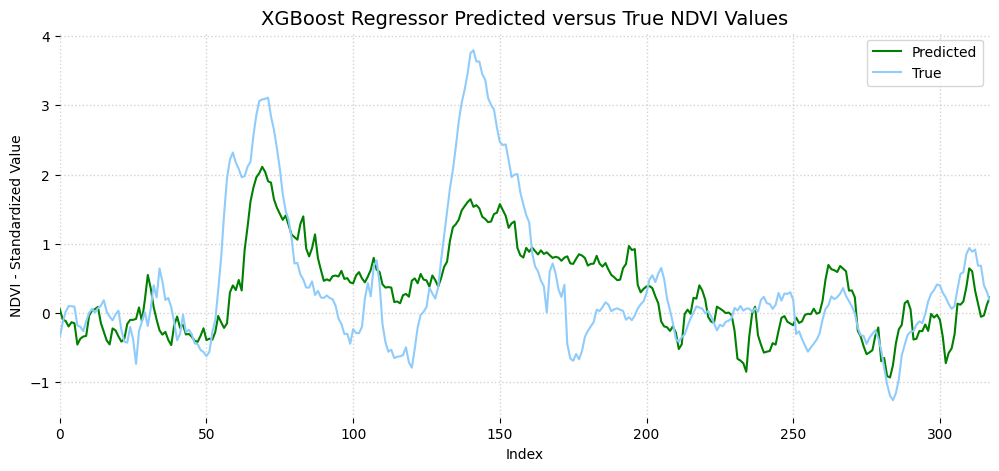

In [ ]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values  in blue
plt.plot(xg_y_pred, label='Predicted', color='green')

# Plot the true values (`y_test`) in red
plt.plot(y_test, label='True', color='#8fccfb')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(xg_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Standardized Value')
plt.title("XGBoost Regressor Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

Let's go through the same process with the Extra Trees Regressor.

In [ ]:
# # ETR
# # Define the ExtraTreesRegressor model
# et_reg = ExtraTreesRegressor(bootstrap=False,
#                                max_depth=18,
#                                max_features=1.0,
#                                min_samples_leaf=1,
#                                min_samples_split=2,
#                                n_estimators=900)

# # Fit the model to the training data
# et_reg.fit(x_train, y_train)

# # Save the model for reproducibility
# dump(et_reg, '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

In [ ]:
# Load the model
et_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

# Use the trained model to make predictions on the test data
et_y_pred = et_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, et_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, et_y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.5646182867266506
Root Mean Squared Error: 0.7514108641260456
R-squared: 0.4576503650422441


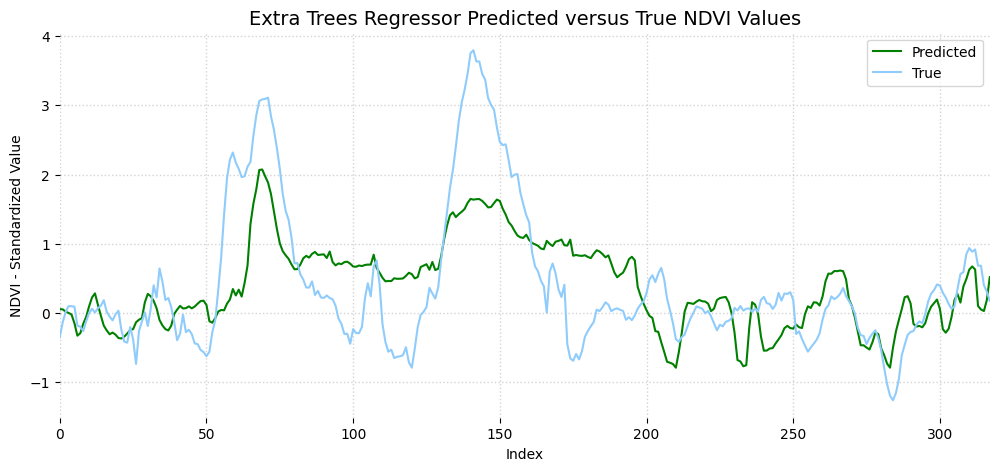

In [ ]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values (`y_pred`) in blue
plt.plot(et_y_pred, label='Predicted', color='green')

# Plot the true values (`y_test`) in red
plt.plot(y_test, label='True', color='#8fccfb')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(et_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Standardized Value')
plt.title("Extra Trees Regressor Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

# **Feature Importance**

After training and evaluating the models, we can look at feature importance scores. This code calculates and visualizes the feature importance scores for the XGBoost regressor and the Extra Trees regressor. Overall, these code snippets allow us to assess the importance of each feature in predicting the target variable using the XGBoost and Extra Trees regressor models. By visualizing the feature importance, we can identify the most influential features in the models' predictions.

Feature Importance Ranking:
PDSI : 0.26328903
SPI30 : 0.16858692
SWE : 0.10683035
SPI90 : 0.09074661
SPI180 : 0.08613881
SPEI90 : 0.05696536
SPEI30 : 0.04005032
EDDI30 : 0.03186807
EDDI90 : 0.030120095
Precip : 0.026700431
PalmerZ : 0.022464998
EDDI180 : 0.020582987
SPEI180 : 0.019669998
Tmin : 0.018245744
Tmax : 0.01774028


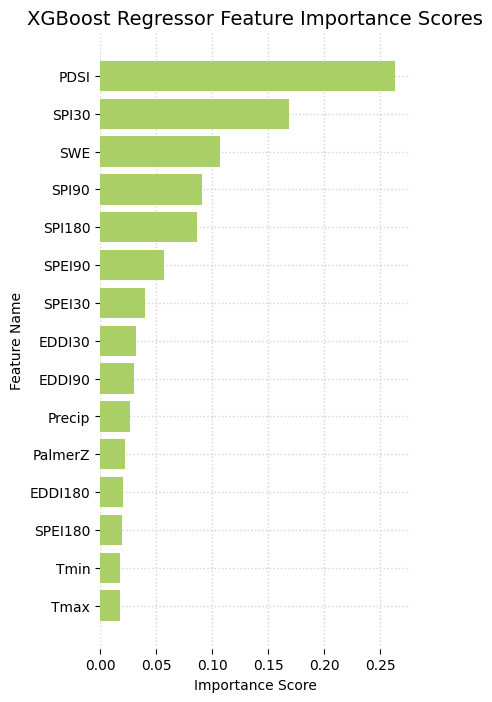

In [ ]:
# XGB
# Get feature importance scores
importance = xg_reg.feature_importances_

# Create a list of feature names
features = list(standardized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set figure size
plt.figure(figsize=(4, 8))

# Create a horizontal bar chart
plt.barh(features, importance_scores, color='#aacf66')

# Add a title and axis labels
plt.title('XGBoost Regressor Feature Importance Scores', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)


# Display the chart
plt.show()

Feature Importance Ranking:
PDSI : 0.19120152551976133
SPI30 : 0.16050186495048738
SWE : 0.13659858893394305
SPI90 : 0.10493978165488277
SPEI90 : 0.07373890525482399
SPEI30 : 0.06564250243215208
SPI180 : 0.06288709590672426
EDDI90 : 0.0357280059077054
EDDI30 : 0.034762539714375415
Precip : 0.026266513349394113
PalmerZ : 0.02603902177317938
Tmin : 0.022848615896761636
EDDI180 : 0.020665815586437958
SPEI180 : 0.019453535729509787
Tmax : 0.018725687389861443


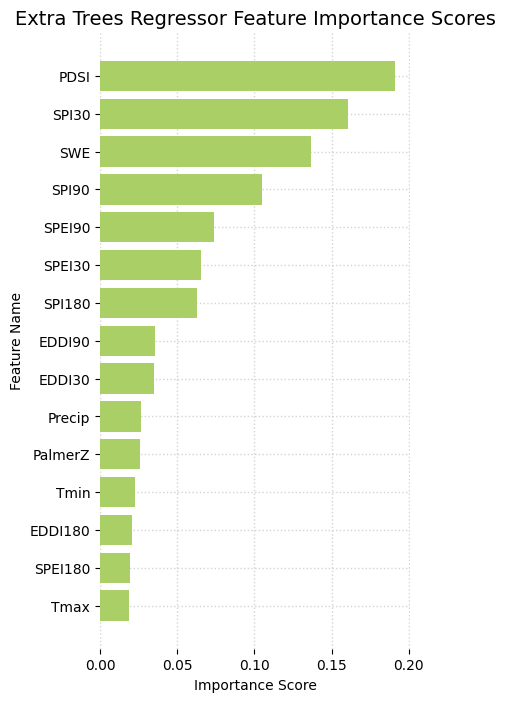

In [ ]:
# ETR
# Get feature importance scores
importance = et_reg.feature_importances_

# Create a list of feature names
features = list(standardized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set figure size
plt.figure(figsize=(4, 8))

# Create a horizontal bar chart
plt.barh(features, importance_scores, color='#aacf66')

# Add a title and axis labels
plt.title('Extra Trees Regressor Feature Importance Scores', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Display the chart
plt.show()

# **XAI**

To finish up, let's get into SHAP. First, this code assigns the column names to the feature_names variable in the same order as they appear in the subset of columns from the standardized DataFrame.

In [ ]:
#create a feature name variable that should match the below
feature_names = ['SWE', 'Min Temp', 'Max Temp',
       'Precipitation', 'PDSI', 'EDDI 30-Day',
       'EDDI 90-Day', 'EDDI 180-Day', 'SPEI 30-Day',
       'SPEI 90-Day', 'SPEI 180-Day', 'SPI 30-Day',
       'SPI 90-Day', 'SPI 180-Day', 'Palmer Z']

standardized_df.columns[1:16]

Index(['SWE', 'Tmin', 'Tmax', 'Precip', 'PDSI', 'PalmerZ', 'EDDI30', 'EDDI90',
       'EDDI180', 'SPEI30', 'SPEI90', 'SPEI180', 'SPI30', 'SPI90', 'SPI180'],
      dtype='object')

Next, our code  loads the XGBoost and Extra Trees regressor models that were previously saved. Then, it uses these models to make predictions on the test data (x_test). Next, it uses the SHAP (SHapley Additive exPlanations) library to explain the results of the predictions. 

These summary plots help in understanding the contribution of each feature towards the predictions made by the respective models. Features with higher absolute SHAP values have a larger impact on the predicted NDVI values.

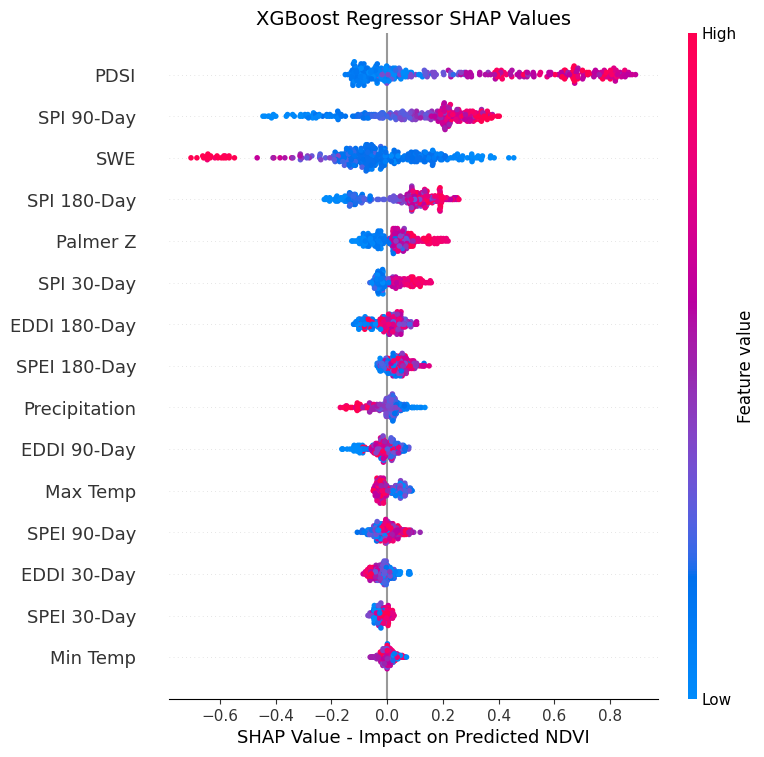

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, show=False)
plt.title("XGBoost Regressor SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

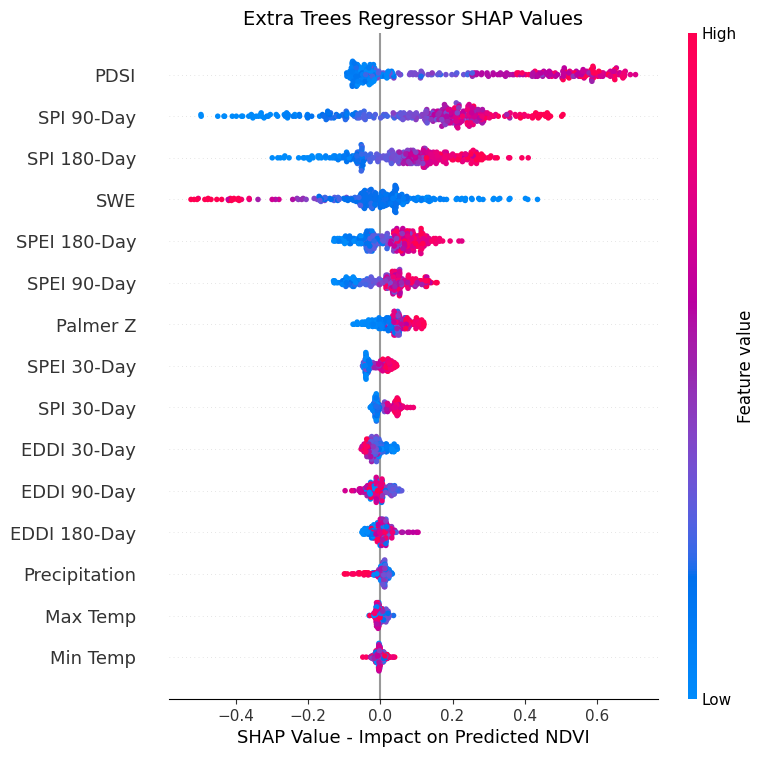

In [ ]:
# Load the model
et_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

# Use the model to make predictions
et_y_pred = et_reg.predict(x_test)

# Explain results using SHAP
et_explainer = shap.Explainer(et_reg)
et_shap_values = et_explainer(x_test)

# Summary plot
shap.summary_plot(et_shap_values, features=x_test, feature_names=feature_names, show=False)
plt.title("Extra Trees Regressor SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

# **Please see the paper linked in the Introduction for an interpretation of the results in this workbook!**